### Load library and Rdata

In [10]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(devtools))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(msigdbr))
suppressPackageStartupMessages(library(UpSetR))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(org.Mm.eg.db))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(EnhancedVolcano))
suppressPackageStartupMessages(library(tools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(knitr))
suppressPackageStartupMessages(library(khroma))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(gridtext))
suppressPackageStartupMessages(library(ggraph))
suppressPackageStartupMessages(library(igraph))

In [11]:
load("SeuratData_DEGs.RData")

### STRING Network
* Using the DEG lists and [STRING Database Tool](https://string-db.org/)
* Confidence = 0.7 (High)


In [12]:
network <- read.csv('String_Shared_Pathway_Multi_Function_Genes.csv') 
graph <- graph_from_data_frame(network, directed = FALSE)
V(graph)$degree <- degree(graph)

In [ ]:
df <- network %>% 
    arrange(desc(experimentally_determined_interaction)) %>% 
    mutate(edges = paste0(node1, ' - ', node2)) %>%
    dplyr::select(node1, node2, edges, combined_score, automated_textmining, coexpression, database_annotated, experimentally_determined_interaction)
colnames(df) <- c('Gene1', 'Gene2', 'Link', 'Score', 'Textmining', 'Coexpression', 'Database', 'Experiment')
df %>% head

,Gene1,Gene2,Link,Score,Textmining,Coexpression,Database,Experiment
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Isg15,Usp18,Isg15 - Usp18,0.999,0.894,0.794,0.4,0.960
2,Ifi35,Nmi,Ifi35 - Nmi,0.906,0.268,0.722,0.0,0.550
3,Irf1,Stat1,Irf1 - Stat1,0.998,0.995,0.425,0.0,0.547
4,Irf9,Stat1,Irf9 - Stat1,0.999,0.997,0.815,0.9,0.418
5,Ifi35,Isg15,Ifi35 - Isg15,0.909,0.619,0.626,0.0,0.414
6,Adar,Eif2ak2,Adar - Eif2ak2,0.877,0.708,0.363,0.0,0.393


### Figure D. STRING Network of core genes 

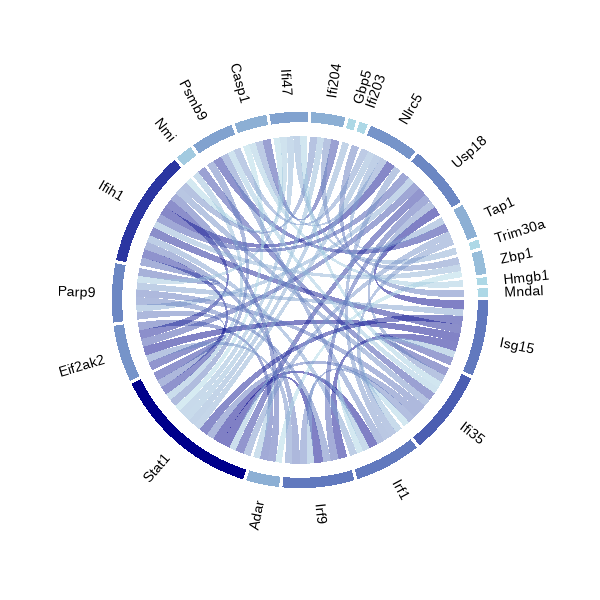

In [14]:
genes <- c(df$Gene1, df$Gene2)
gene_degree <- table(genes)

options(repr.plot.width = 5, repr.plot.height = 5)
# Create a named color palette function for each metric
color_palette_score <- colorRampPalette(c("lightblue", "darkblue"))

# Assign colors to each gene based on its degree
gene_colors_score <- color_palette_score(max(gene_degree))[as.numeric(gene_degree)]

# Convert gene_degree to a named vector for easier reference
names(gene_colors_score) <- names(gene_degree)

# Adjust margin and plot size using circos.par
circlize::circos.clear()  # Clear any previous settings
circlize::circos.par(track.margin = c(0.03, 0.03),   # Margin between tracks and the edge
           canvas.xlim = c(-1.1, 1.1),     # Reduce x-axis limits to make the plot smaller
           canvas.ylim = c(-1.1, 1.1))     # Reduce y-axis limits to make the plot smaller

# Plot the chord diagram
circlize::chordDiagram(df[, c("Gene1", "Gene2", "Score")], 
             grid.col = gene_colors_score,   # Keep the outer ring colors based on gene degree
             col = color_palette_score(100)[as.numeric(cut(df$Score, breaks = 100))],  # Color edges by Score directly
             transparency = 0.5,
             annotationTrack = "grid",  # Keep grid for better spacing
             preAllocateTracks = list(track.height = 0.1))  # Extra space for gene labels

# Add gene labels on the outer ring
circlize::circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  gene = circlize::get.cell.meta.data("sector.index")
  circlize::circos.text(x = circlize::CELL_META$xcenter, y = circlize::CELL_META$ylim[1] + 0.1,
                        labels = gene, facing = "clockwise", niceFacing = TRUE,
                        adj = c(0, 0.5), cex = 0.7)
}, bg.border = NA) 

### Figure E. Heatmap of evidence channels for top gene pairs

In [35]:
network_scores <- df %>% dplyr::select(Score, Textmining, Coexpression, Database, Experiment) 
rownames(network_scores) <- df$Link
network_scores <- network_scores %>% arrange(desc(Score)) %>% head(15)
network_scores

,Score,Textmining,Coexpression,Database,Experiment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Isg15 - Usp18,0.999,0.894,0.794,0.4,0.960
Irf9 - Stat1,0.999,0.997,0.815,0.9,0.418
Irf1 - Stat1,0.998,0.995,0.425,0.0,0.547
Eif2ak2 - Isg15,0.990,0.843,0.887,0.5,0.000
Irf9 - Isg15,0.983,0.807,0.902,0.0,0.214
Ifih1 - Nlrc5,0.973,0.964,0.252,0.0,0.093
Isg15 - Stat1,0.964,0.888,0.411,0.5,0.000
Ifih1 - Isg15,0.958,0.867,0.669,0.0,0.136
Eif2ak2 - Ifih1,0.955,0.895,0.569,0.0,0.084


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


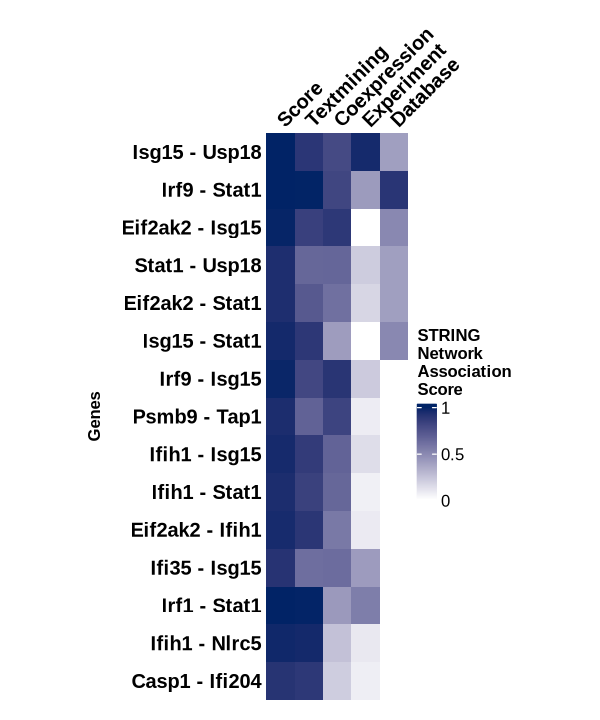

In [47]:
options(repr.plot.width = 5, repr.plot.height = 6)
Heatmap(network_scores, name = "STRING\nNetwork\nAssociation\nScore", col = circlize::colorRamp2(c(0, 1), c("white", "#002366")), 
        width = unit(3, "cm"), height = unit(12, "cm"), 
        column_title = NULL,
        row_title = "Genes", 
        row_title_side = "left", 
        show_column_dend = FALSE,
        show_row_dend = FALSE,
        row_names_side = "left",
        column_names_side = "top",
        cluster_rows = TRUE, 
        cluster_columns = TRUE, 
        column_title_gp = gpar(fontsize = 10, fontface = "bold"), 
        row_title_gp = gpar(fontsize = 10, fontface = "bold"),
        column_names_gp = gpar(fontsize = 12, fontface = "bold"),
        row_names_gp = gpar(fontsize = 12, fontface = "bold"),
        column_names_rot = 45)